In [1]:
!pip install chart-studio

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.4/64.4 kB 2.2 MB/s eta 0:00:00


In [2]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt

import re
from nltk.corpus import stopwords
from nltk import word_tokenize
STOPWORDS = set(stopwords.words('english'))
from bs4 import BeautifulSoup
#import plotly.graph_objs as go
#import plotly.plotly as py
import cufflinks
from IPython.core.interactiveshell import InteractiveShell
import plotly.figure_factory as ff
InteractiveShell.ast_node_interactivity = 'all'
from plotly.offline import iplot
cufflinks.go_offline()
cufflinks.set_config_file(world_readable=True, theme='pearl')

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
import seaborn as sns
from keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences
#from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from keras.callbacks import EarlyStopping
from keras.layers import Dropout

/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning:

unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']

/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning:

file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tensorflow13GcsFileSystemE']



In [4]:
df = pd.read_csv('/kaggle/input/us-consumer-finance-complaints/consumer_complaints.csv')

/tmp/ipykernel_29/4042890859.py:1: DtypeWarning:

Columns (5,11) have mixed types. Specify dtype option on import or set low_memory=False.



In [5]:
df.head()

,date_received,product,sub_product,issue,sub_issue,consumer_complaint_narrative,company_public_response,company,state,zipcode,tags,consumer_consent_provided,submitted_via,date_sent_to_company,company_response_to_consumer,timely_response,consumer_disputed?,complaint_id
0,08/30/2013,Mortgage,Other mortgage,"Loan modification,collection,foreclosure",NaN,NaN,NaN,U.S. Bancorp,CA,95993,NaN,NaN,Referral,09/03/2013,Closed with explanation,Yes,Yes,511074
1,08/30/2013,Mortgage,Other mortgage,"Loan servicing, payments, escrow account",NaN,NaN,NaN,Wells Fargo & Company,CA,91104,NaN,NaN,Referral,09/03/2013,Closed with explanation,Yes,Yes,511080
2,08/30/2013,Credit reporting,NaN,Incorrect information on credit report,Account status,NaN,NaN,Wells Fargo & Company,NY,11764,NaN,NaN,Postal mail,09/18/2013,Closed with explanation,Yes,No,510473
3,08/30/2013,Student loan,Non-federal student loan,Repaying your loan,Repaying your loan,NaN,NaN,"Navient Solutions, Inc.",MD,21402,NaN,NaN,Email,08/30/2013,Closed with explanation,Yes,Yes,510326
4,08/30/2013,Debt collection,Credit card,False statements or representation,Attempted to collect wrong amount,NaN,NaN,Resurgent Capital Services L.P.,GA,30106,NaN,NaN,Web,08/30/2013,Closed with explanation,Yes,Yes,511067


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 555957 entries, 0 to 555956
Data columns (total 18 columns):
 #   Column                        Non-Null Count   Dtype 
---  ------                        --------------   ----- 
 0   date_received                 555957 non-null  object
 1   product                       555957 non-null  object
 2   sub_product                   397635 non-null  object
 3   issue                         555957 non-null  object
 4   sub_issue                     212622 non-null  object
 5   consumer_complaint_narrative  66806 non-null   object
 6   company_public_response       85124 non-null   object
 7   company                       555957 non-null  object
 8   state                         551070 non-null  object
 9   zipcode                       551452 non-null  object
 10  tags                          77959 non-null   object
 11  consumer_consent_provided     123458 non-null  object
 12  submitted_via                 555957 non-null  object
 13 

In [7]:
df['product'].value_counts()

Mortgage                   186475
Debt collection            101052
Credit reporting            91854
Credit card                 66468
Bank account or service     62563
Consumer Loan               20990
Student loan                15839
Payday loan                  3877
Money transfers              3812
Prepaid card                 2470
Other financial service       557
Name: product, dtype: int64

In [8]:
data1=df[['product', 'consumer_complaint_narrative']]

In [9]:
data1.head()

,product,consumer_complaint_narrative
0,Mortgage,NaN
1,Mortgage,NaN
2,Credit reporting,NaN
3,Student loan,NaN
4,Debt collection,NaN


In [10]:
data1=data1.dropna()

In [11]:
data1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 66806 entries, 190126 to 553096
Data columns (total 2 columns):
 #   Column                        Non-Null Count  Dtype 
---  ------                        --------------  ----- 
 0   product                       66806 non-null  object
 1   consumer_complaint_narrative  66806 non-null  object
dtypes: object(2)
memory usage: 1.5+ MB


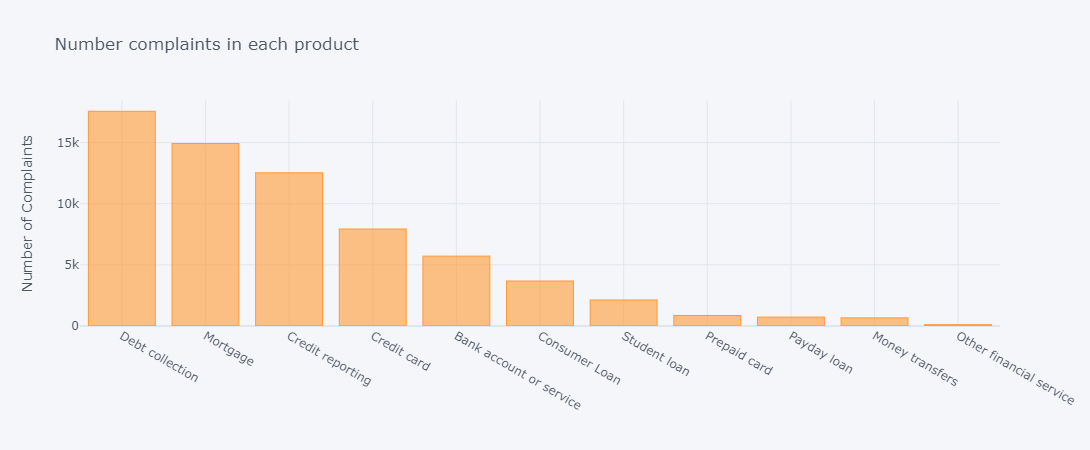

In [12]:
data1['product'].value_counts().sort_values(ascending=False).iplot(kind='bar', yTitle='Number of Complaints', 
                                                                title='Number complaints in each product')

In [13]:
data1.reset_index(inplace = True)

In [14]:
def print_plot(index):
    example = data1[data1.index == index][['consumer_complaint_narrative', 'product']].values[0]
    if len(example) > 0:
        print(example[0])
        print('Product:', example[1])

In [15]:
data1.head()

,index,product,consumer_complaint_narrative
0,190126,Debt collection,XXXX has claimed I owe them {$27.00} for XXXX ...
1,190135,Consumer Loan,Due to inconsistencies in the amount owed that...
2,190155,Mortgage,In XX/XX/XXXX my wages that I earned at my job...
3,190207,Mortgage,I have an open and current mortgage with Chase...
4,190208,Mortgage,XXXX was submitted XX/XX/XXXX. At the time I s...


In [16]:
print_plot(1)

Due to inconsistencies in the amount owed that I was told by M & T Bank and the amount that was reported to the credit reporting agencies, I was advised to write a good will letter in order to address the issue and request the negative entry be removed from my credit report all together. I had a vehicle that was stolen and it was declared a total loss by insurance company. The insurance company and the GAP insurancw companypaid the outstanding balance of the loan, but I was told by M & T Bank that there was still a balance due on the loan. In good faith, without having received any proof as to why there was still a balance, I made a partial payment towards the remaining debt. I then sent the goodwill letter still offering to pay the remainder of the debt, but in exchange for the removal of the negative entry on my credit report. At one point, in XXXX 2015, per my credit monitoring agency, it showed a delinquent balance of {$0.00}, but when I checked my credit report again on XXXX XXXX 

In [17]:
print_plot(100)

I contacted Drivetime on several different occasions regarding a car loan I had with them account # XXXX i do not have the number for the other loan that was removed also from the credit bureau with a positive credit rating that was closed and paid in full. The company insisted on avoiding an agreement entered into by myself and XXXX of their company representative in a corporate position they have the agreed upon resolution and can provide your agency with a copy of the same because i do not have the capability to do so with my computer. Drivetime during the month of XXXX XXXX removed my credit reporting information from XXXX credit bureaus reporting agencies I believe XXXX and XXXX XXXX I discovered in or about XXXX XXXX that my positive credit ratings were no longer in the XXXX and XXXX credit bureaus and that another positive account for another car loan was no longer reporting in my credit file. these removals adversely affecxted my credit ratings and as such my ability to purchas

In [18]:
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
STOPWORDS = set(stopwords.words('english'))

def clean_text(text):
    """
        text: a string
        
        return: modified initial string
    """
    text = text.lower() # lowercase text
    text = REPLACE_BY_SPACE_RE.sub(' ', text) # replace REPLACE_BY_SPACE_RE symbols by space in text. substitute the matched string in REPLACE_BY_SPACE_RE with space.
    text = BAD_SYMBOLS_RE.sub('', text) # remove symbols which are in BAD_SYMBOLS_RE from text. substitute the matched string in BAD_SYMBOLS_RE with nothing. 
    text = text.replace('x', '')
#    text = re.sub(r'\W+', '', text)
    text = ' '.join(word for word in text.split() if word not in STOPWORDS) # remove stopwors from text
    return text
data1['consumer_complaint_narrative'] = data1['consumer_complaint_narrative'].apply(clean_text)

In [19]:
data1['consumer_complaint_narrative'] = data1['consumer_complaint_narrative'].str.replace('\d+', '')

/tmp/ipykernel_29/3936510320.py:1: FutureWarning:

The default value of regex will change from True to False in a future version.



In [20]:
print_plot(1)

due inconsistencies amount owed told bank amount reported credit reporting agencies advised write good letter order address issue request negative entry removed credit report together vehicle stolen declared total loss insurance company insurance company gap insurancw companypaid outstanding balance loan told bank still balance due loan good faith without received proof still balance made partial payment towards remaining debt sent goodwill letter still offering pay remainder debt echange removal negative entry credit report one point  per credit monitoring agency showed delinquent balance  checked credit report  delinquent balance  monies gap insurance insurance company paid bank says still owe   already paid contacted bank via return receipt mail given courtesy response yet
Product: Consumer Loan


In [21]:
print_plot(100)

contacted drivetime several different occasions regarding car loan account # number loan removed also credit bureau positive credit rating closed paid full company insisted avoiding agreement entered company representative corporate position agreed upon resolution provide agency copy capability computer drivetime month removed credit reporting information credit bureaus reporting agencies believe discovered positive credit ratings longer credit bureaus another positive account another car loan longer reporting credit file removals adversely affected credit ratings ability purchase something lower interest rate never missed payment drivetime company car loans inclusive different auto loans destroy credit ratings despicable spoke today regarding issues response drivetime process updating consumers credit files consumers credit files removed credit bureaus updated however know process performed records updated corrected process timeframes process take furthermore process involves consumer

In [22]:
# The maximum number of words to be used. (most frequent)
MAX_NB_WORDS = 50000
# Max number of words in each complaint.
MAX_SEQUENCE_LENGTH = 250
# This is fixed.
EMBEDDING_DIM = 100

tokenizer = Tokenizer(num_words=MAX_NB_WORDS, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(data1['consumer_complaint_narrative'].values)

word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 56802 unique tokens.


In [23]:
X = tokenizer.texts_to_sequences(data1['consumer_complaint_narrative'].values)
X = pad_sequences(X)
print('Shape of data tensor:', X.shape)

Shape of data tensor: (66806, 381)


In [24]:
Y = pd.get_dummies(data1['product']).values
print('Shape of label tensor:', Y.shape)

Shape of label tensor: (66806, 11)


In [25]:
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.10, random_state = 42)
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

(60125, 381) (60125, 11)
(6681, 381) (6681, 11)


In [26]:

model = Sequential()
model.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X.shape[1]))
model.add(SpatialDropout1D(0.2))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(11, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 381, 100)          5000000   
                                                                 
 spatial_dropout1d (SpatialD  (None, 381, 100)         0         
 ropout1D)                                                       
                                                                 
 lstm (LSTM)                 (None, 100)               80400     
                                                                 
 dense (Dense)               (None, 11)                1111      
                                                                 
Total params: 5,081,511
Trainable params: 5,081,511
Non-trainable params: 0
_________________________________________________________________
None


In [27]:
epochs = 5
batch_size = 64

history = model.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size,validation_split=0.1,callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])

Epoch 1/5
846/846 [==============================] - 1637s 2s/step - loss: 1.1316 - accuracy: 0.6316 - val_loss: 0.7705 - val_accuracy: 0.7672
Epoch 2/5
846/846 [==============================] - 1528s 2s/step - loss: 0.8565 - accuracy: 0.7411 - val_loss: 0.7179 - val_accuracy: 0.7865
Epoch 3/5
846/846 [==============================] - 1507s 2s/step - loss: 0.6262 - accuracy: 0.8131 - val_loss: 0.6212 - val_accuracy: 0.8194
Epoch 4/5
846/846 [==============================] - 1495s 2s/step - loss: 0.5244 - accuracy: 0.8455 - val_loss: 0.7598 - val_accuracy: 0.7456
Epoch 5/5
846/846 [==============================] - 1492s 2s/step - loss: 0.4734 - accuracy: 0.8612 - val_loss: 0.5750 - val_accuracy: 0.8329


In [28]:
accr = model.evaluate(X_test,Y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

209/209 [==============================] - 25s 121ms/step - loss: 0.6204 - accuracy: 0.8240
Test set
  Loss: 0.620
  Accuracy: 0.824


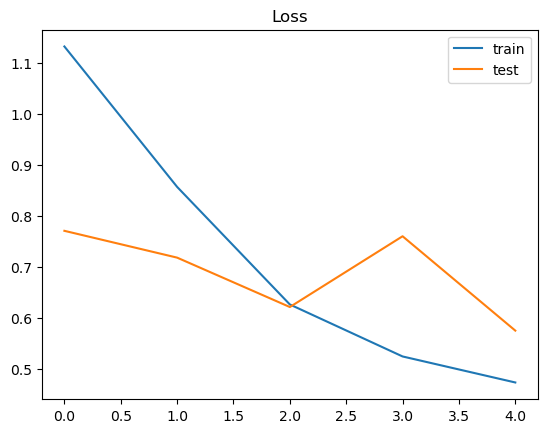

In [29]:
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show();

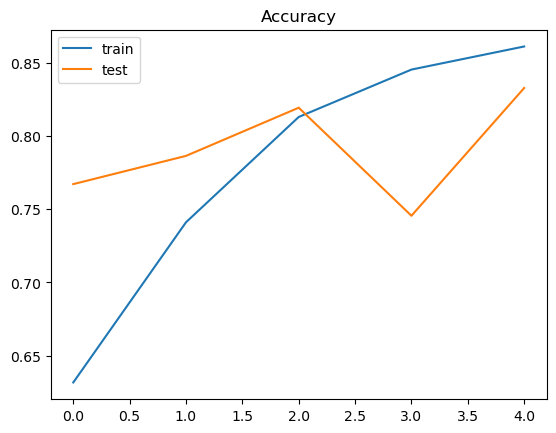

In [32]:
plt.title('Accuracy')
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.legend()
plt.show();

In [69]:
new_complaint = ['I am a victim of identity theft and someone stole my identity and personal information to open up a Visa credit card account with Bank of America. The following Bank of America Visa credit card account do not belong to me : XXXX.']
seq = tokenizer.texts_to_sequences(new_complaint)
padded = pad_sequences(seq, maxlen=381)
pred = model.predict(padded)
labels=['Bank account or service','Consumer Loan','Credit card','Credit reporting','Debt collection ','Money transfers','Mortgage','Other financial service','Payday loan','Prepaid card','Student loan']
print(pred,labels[np.argmax(pred)])

1/1 [==============================] - 0s 126ms/step
[[0.04120111 0.02650907 0.6356575  0.24856284 0.03686508 0.00088145
  0.00376469 0.00108732 0.00132315 0.00293942 0.00120836]] Credit card
